# COVID-19 Literature Clustering

<h4><center>t-SNE Scatter Plot from CORD-19</center></h4>

In [ ]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/cover/bokeh_plot.png', width=800, height=800)

<h2 style="color:black;">The full version of the interactive plot:</h2>

## https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html

<h2 style="color:black;">GitHub:</h2>

## https://github.com/MaksimEkin/COVID19-Literature-Clustering

<h2 style="color:black;">Link to the paper:</h2>

## https://www.maksimeren.com/publication/eren_doceng2020/

<br>
<br>

## How to Cite This Work?
```
@inproceedings{10.1145/3395027.3419591, 
	author = {Eren, Maksim Ekin and Solovyev, Nick and Raff, Edward and Nicholas, Charles and Johnson, Ben}, 
	title = {COVID-19 Kaggle Literature Organization}, 
	year = {2020}, 
	isbn = {9781450380003}, 
	publisher = {Association for Computing Machinery}, 
	address = {New York, NY, USA}, 
	url = {https://doi.org/10.1145/3395027.3419591}, 
	doi = {10.1145/3395027.3419591}, 
	abstract = {The world has faced the devastating outbreak of Severe Acute Respiratory Syndrome Coronavirus-2 (SARS-CoV-2), or COVID-19, in 2020. Research in the subject matter was fast-tracked to such a point that scientists were struggling to keep up with new findings. With this increase in the scientific literature, there arose a need for organizing those documents. We describe an approach to organize and visualize the scientific literature on or related to COVID-19 using machine learning techniques so that papers on similar topics are grouped together. By doing so, the navigation of topics and related papers is simplified. We implemented this approach using the widely recognized CORD-19 dataset to present a publicly available proof of concept.}, 
	booktitle = {Proceedings of the ACM Symposium on Document Engineering 2020},
	articleno = {15}, 
	numpages = {4}, 
	keywords = {clustering, document visualization, COVID-19, dimensionality reduction}, 
	location = {Virtual Event, CA, USA}, series = {DocEng '20} }
```

# Goal
Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. Can clustering similar research articles together simplify the search for related publications? How can the content of the clusters be qualified?

By using clustering for labeling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topics will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modeling will be performed to find the keywords of each cluster.

By using Bokeh, the plot will be interactive. Users will have the option of seeing the plot as a whole or filtering the data by cluster. If a narrower scope is required, the plot will also have a search function that will limit the output to only papers containing the search term. Hovering over points on the plot will give basic information like title, author, journal, and abstract. Clicking on a point will bring up a menu with a URL that can be used to access the full publication.

This is a difficult time in which health care workers, sanitation staff, and much other essential personnel are out there keeping the world afloat. Sitting at home has given us time to try to help in our own way. We hope that our work will have some impact on the fight against COVID-19. It should be noted, however, that we are not epidemiologists, and it is not our place to gauge the importance of these papers. This tool was created to help make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations.


#### We welcome feedback so that we can continue to improve this project.

<br>
<br>
<br>


# Approach:

- Parse the text from the body of each document using Natural Language Processing (NLP).
- Turn each document instance di into a feature vector Xi using Term Frequency–Inverse Document Frequency (TF-IDF).
- Apply Dimensionality Reduction to each feature vector Xi using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two-dimensional plane X embedding Y1.
- Use Principal Component Analysis (PCA) to project down the dimensions of X to several dimensions that will keep .95 variance while removing noise and outliers in embedding Y2.
- Apply k-means clustering on Y2, where k is 20, to label each cluster on Y1.
- Apply Topic Modeling on X using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster.
- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD).

<br>
<br>

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>
<br>

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [ ]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

In [ ]:
meta_df.info()

### Fetch All of JSON File Path

Get path to all JSON files:

In [ ]:
all_json = ! ls $root_path/document_parses/pdf_json
len(all_json)

In [ ]:
all_json[:5]

### Helper Functions

In [ ]:
all_json = [root_path + "document_parses/pdf_json/" + s for s in all_json]
all_json[:5]

 File Reader Class

In [ ]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

In [ ]:
from tqdm import tqdm
all_json_clean = list()
for idx, entry in tqdm(enumerate(all_json), total=len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.body_text) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

In [ ]:
import random

random.seed(42)

all_json = random.sample(all_json, 15000)

In [ ]:
all_json[:5]

Helper function adds a break after every word when the character length reaches a certain amount. This is for the interactive plot so that the hover tool fits the screen.

In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read the articles into a DataFrame that can be used easily:

In [ ]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

In [ ]:
df_covid.info()

## Take a Look at the Data:

In [ ]:
df_covid.head()

# Data Pre-processing

Unfortunately, running the next steps of the notebook is not possible on the full dataset within Kaggle. **The full plot is available is at https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html**.

In Kaggle we will limit the dataframe to **10,000** instances

In [ ]:
df = df_covid.sample(10000, random_state=42)
del df_covid

Now that we have our dataset loaded, we need to clean up the text to improve any clustering or classification efforts. First, let's drop Null values:

In [ ]:
df.dropna(inplace=True)
df.info()

### Handling multiple languages
Next, we are going to determine the language of each paper in the data frame. Not all of the sources are English and the language needs to be identified so that we know how to handle these instances

In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [ ]:
df = df[df['language'] == 'en'] 
df.info()

Download the spacy bio parser

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

Now the above stopwords are used in everyday English text. Research papers will often use words that don't contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

Let's take a look at the language distribution in the dataset

### Next let's create a function that will process the text data for us. 
For this purpose, we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [ ]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose, we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based on the content of the body text. The maximum number of features will be the maximum number of unique words out of all of the papers

In [ ]:
text = df['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. This will reduce the complexity of our dimensionality reduction step and filter noise.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

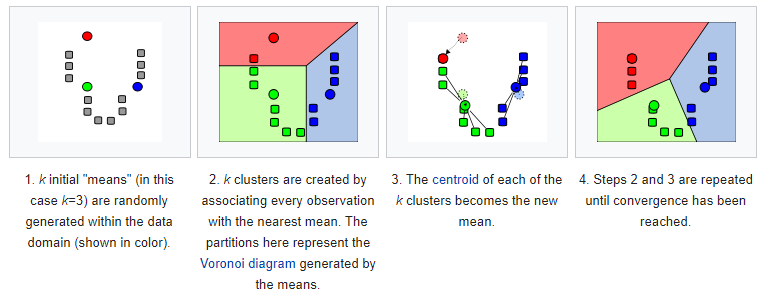

[source](https://en.wikipedia.org/wiki/K-means_clustering)

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Run k-means

In [ ]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. t-SNE will attempt to preserve the relations of the higher dimensional data as closely as possible when shrunk to 2D. The similar article will thus be in closer proximity to each other.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

So that step took a while! Let's take a look at what our data looks like when compressed into 2 dimensions. 

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. t-SNE was able to reduce the dimensionality of the texts, but now clustering is required. <br>
Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. Interestingly, both k-means and t-SNE can find independent clusters even though they were run independently. This shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels are spread out on the plot. This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it was hard to cleanly separate them. 

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each cluster. K-means clustered the articles but did not label the topics. Through topic modeling, we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
Image(url='https://miro.medium.com/max/1276/0*Sj65xR38wDwuxhtr.jpg', width=800, height=800)


[source](https://miro.medium.com/max/1276/0*Sj65xR38wDwuxhtr.jpg)

First, we will create 20 vectorizers, one for each of our cluster labels

In [ ]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorizers[0]

Now we will vectorize the data from each of our clusters

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
len(vectorized_data)

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

For each cluster, we had created a corresponding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
all_keywords[0][:10]

In [ ]:
len(all_keywords)

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time-intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [ ]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [ ]:
import pickle

# save the COVID-19 DataFrame
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

# Plotting the data
The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are nearby. To try to understand what the similarities may be, we have also performed topic modeling on each cluster of papers to pick out the key terms. 

First lets download our scripts from the repository that contains the plot settings and text:

In [ ]:
! mkdir lib
! ls

In [ ]:
! wget https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/plot_text.py
! wget https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/call_backs.py
! mv plot_text.py lib/.
! mv call_backs.py lib/.
! ls lib/

In [ ]:
# required libraries for plot
from lib.plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from lib.call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

## Load the Keywords per Cluster

In [ ]:
import os

topic_path = os.path.join(os.getcwd(), 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

## Setup

In [ ]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

## Widgets

In [ ]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider
# column(,,widgetbox(keyword),,widgetbox(slider),, notes, cite, cite2, cite3), plot

## Style

In [ ]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "stretch_width"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

## SHOW

In [ ]:
# LAYOUT OF THE PAGE
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"


# show
output_file('t-sne_covid-19_interactive.html')
show(l)

# Conclusion
In this project, we have attempted to cluster published literature on COVID-19 and reduce the dimensionality of the dataset for visualization purposes. This has allowed for an interactive scatter plot of papers related to COVID-19, in which material of similar themes is grouped. Grouping the literature in this way allows for professionals to quickly find material related to a central topic. Instead of having to manually search for related work, every publication is connected to a larger topic cluster. [...]
 
The clustering of the data was done through k-means on a pre-processed, vectorized version of the literature’s body text. As k-means simply split the data into clusters, topic modeling through LDA was performed to identify keywords. This gave the topics that were prevalent in each of the clusters.

K-means and t-SNE were able to independently find clusters, showing that relationships between papers can be identified and measured. Papers written on highly similar topics are typically near each other on the plot and bear the same k-means label. However, due to the complexity of the dataset, k-means and t-SNE will sometimes arrive at different decisions. The topics of much of the given literature are continuous and will not have a concrete decision boundary. In these conditions, our approach performs quite well to organize the literature by similarity. 

- Look at clusters
- Look at titles/abstract to see that they are similar
- Use classification to see if k-means found effective decisions

As neither of the authors is qualified to assess the meaning of the literature, the analysis by inspection was performed solely on the titles. Even so, it was apparent that articles on key topics could be easily found near each other. For example [MASK CLUSTER EXAMPLE FROM FINAL PLOT].  We believe that health professionals can use this tool to find real links in the texts. By organizing the literature, qualified people can quickly find related publications that answer the task questions. 

"This project can further be improved by abstracting the underlying data analysis techniques as described in this notebook to develop a user interface/tool that presents the related articles in a user-friendly manner."

<br>
<br>
<br>

**Some areas we thought were great:** (pros)
- The tool is saved as an HTML file. It can be downloaded and used locally/offline.
- It is portable/mobile, easily deployable, and failover safe; the risk of denial of service in the case of emergencies such as the loss of network connection is mitigated
- Dimensionality reduction allows for the whole dataset to be easily accessible. The papers are all up on the plot and can be quickly examined by hovering over them. If the abstract seems interesting, the user can click on the point to bring up a text box with more information that will contain a link to the full paper
- Patterns in the data found through clustering/dimensionality reduction may not be readily apparent to researchers. These unsupervised techniques can show humans hidden connections in the literature
- If the topics/clusters are not narrow enough for the user, a search for a key term will only bring up papers that contain the search term. Search can be performed inside of a selected cluster or the entire dataset if preferred.
- A surface-level examination of the plot showed some very interesting organization of the data. For example, one subcluster consisted of papers that tried to determine the efficacy of masks in preventing the spread of COVID-19.
- This work can be easily replicated and modified as needed, serving as a foundation for future projects.

<br>

**Future thoughts to consider:** (cons)
- Possible false positives, difficult to draw an exact line between subjects
- K-means and t-SNE are unsupervised approaches that will not necessarily predictably group instances. Due to their unsupervised nature, this is not an exact science 
- Not labeled data; no certainty.
- No in between, clustering either looks ok or is very wrong
- Loss of foreign language papers. This leads to the loss of experience from different geographic locations in dealing with COVID-19
- The algorithms used in this notebook are stochastic so the results may vary depending on the random state. In this notebook, all of the algorithms are set to random state 42 (the meaning of life) to ensure reproducible results

# Citation/Sources

Kaggle Submission: [COVID-19 Literature Clustering | Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Unsupervised-Learning:-Clustering-with-K-Means)
 
 ```
@inproceedings{Raff2020,
	author = {Raff, Edward and Nicholas, Charles and McLean, Mark},
	booktitle = {The Thirty-Fourth AAAI Conference on Artificial Intelligence},
	title = {{A New Burrows Wheeler Transform Markov Distance}},
	url = {http://arxiv.org/abs/1912.13046},
	year = {2020},
}
```
```
@misc{Kaggle,
	author = {Kaggle},
	title = {COVID-19 Open Research Dataset Challenge (CORD-19)},
	year = {2020},
	month = {March},
	note = {Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for   Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.},
	howpublished = {\url{https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge}}
}
```
```
@inproceedings{Shakespeare,
	author = {Nicholas, Charles},
	title = {Mr. Shakespeare, Meet Mr. Tucker},
	booktitle = {High Performance Computing and Data Analytics Workshop},
	year = {2019},
	month = {September},
	location = { Linthicum Heights, MD, USA},
}
```
```
@inproceedings{raff_lzjd_2017,
	author = {Raff, Edward and Nicholas, Charles},
	title = {An Alternative to NCD for Large Sequences, Lempel-Ziv Jaccard Distance},
	booktitle = {Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
	series = {KDD '17},
	year = {2017},
	isbn = {978-1-4503-4887-4},
	location = {Halifax, NS, Canada},
	pages = {1007--1015},
	numpages = {9},
	url = {http://doi.acm.org/10.1145/3097983.3098111},
	doi = {10.1145/3097983.3098111},
	acmid = {3098111},
	publisher = {ACM},
	address = {New York, NY, USA},
	keywords = {cyber security, jaccard similarity, lempel-ziv, malware classification, normalized compression distance},
}
```

<br>
<br>

**Thank you for looking at our notebook. We greatly appreciate tips, suggestions, and upvotes :)** <br>
**If you would like to check out the interactive plot with the full dataset, please visit:**

https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html